In [1]:
from pydaqmx_helper.dac import DAC
import time
import numpy as np
import matplotlib.pyplot as plt
import serial

In [2]:
# Create a DAC instance for channel 0
myDAC = DAC(0)

In [59]:
from serial.tools import list_ports
for p in list_ports.comports():
    print(p)

COM1 - Communications Port (COM1)
COM4 - USB Serial Port (COM4)


In [60]:
ser = serial.Serial(
    "com4",
    baudrate=57600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    xonxoff=False,
    timeout=1, # seconds
)

In [61]:
# must define a function to change string to bytes to send to the device
def data(mystring):
    return bytes(mystring+'\n','utf-8')

ser.flushInput() # fresh start for data

### Configuring Device

In [62]:
# query device configrations
ser.write(data("&Q\n")) # query 
ser.readlines()

[b'RBD Instruments: PicoAmmeter\r\n',
 b'Firmware Version: 02.09\r\n',
 b'Build: 1-25-18\r\n',
 b'R, Range=AutoR\r\n',
 b'I, sample Interval=0000 mSec\r\n',
 b'L, Chart Log Update Interval=0200 mSec\r\n',
 b'B, BIAS=OFF\r\n',
 b'F, Filter=016\r\n',
 b'V, FormatLen=8\r\n',
 b'CA, Autocal=OFF\r\n',
 b'G, AutoGrounding=DISABLED\r\n',
 b'Q, State=MEASURE\r\n',
 b'P, PID=PES_1     \r\n']

In [63]:
# enabling auto range
ser.write(data("&R0")) #set to autoranging for magnitude of current
ser.readline()

b'&R, Range=AutoR\r\n'

In [64]:
# # setting filter to reduce noise
ser.write(data("&F000")) 
# # helps dealing with~ low currents at an anode, which might fluctuate due to environmental noise.
ser.readline()

b'&F, Filter=000\r\n'

In [65]:
# ser.write(data("&V8"))  # set to 8 decimal places for maximum precision
# ser.readline()

In [66]:
# ser.write(data("&I0100"))  # set to 100ms auto sampling
# ser.readline()

### Measuring Current from pico ammeter

In [ ]:
# extracting current value from string returned:

def extracter(answer):
    pieces = answer.split(',')
    # print(pieces)
    currentval = float(pieces[-2])
#     if len(pieces) > 2:
#         currentval = float(pieces[2])
#     else:
#         return None
#     if len(pieces) > 3:
#         currentval = float(pieces[2])
#     else:
#         return None
    if pieces[-1] == 'mA': 
        return currentval * 1e-3
    if pieces[-1] == 'uA':
        return currentval * 1e-6
    if pieces[-1] == 'nA':
        return currentval * 1e-9
    if pieces[-1] == 'pA':
        return currentval * 1e-12
    
myDAC.writeVoltage(vmapperinverse(1.5))
ser.write(data('&S'))
ans = ser.readline().decode("utf-8").rstrip()
print(ans)
print(len(ans))
print(ans[1])
pieces = ans.split(',')
print(pieces)
print(pieces[2])
print(ans.split(',')[0])
for i in range(0,100):
    myDAC.writeVoltage(vmapperinverse(1.5))
    ser.write(data('&S')) 
# code used to get correct reading of current at starting point before starting the loop below

&S=,Range=002nA,+0.0935542,nA
29
S
['&S=', 'Range=002nA', '+0.0935542', 'nA']
+0.0935542
&S=


In [ ]:
#  defining a function to map 0V on the daq to -5V on the actual output

def vmapper(Vdaq):
    return 2 * Vdaq - 5

# define inverse function to input whatever desired voltage range

def vmapperinverse(V):
    return (V + 5)/2

In [85]:
# applying voltage across anode

iv = []
cmeasured = []

voltage = 1.5
numsamples = 10

while voltage > -1.5:
    # set sample interval
    #print(voltage)

    iv.append(voltage)
    myDAC.writeVoltage(vmapperinverse(voltage))
    #print(voltage)
    
    if voltage == 1.5:
        time.sleep(3)

    time.sleep(0.2) # stabilise voltage inputted
    cm = [] # empty list for samples which will be taken the avg of
    for _ in range(numsamples): # underscore removes the need for a variable
        ser.write(data('&S\n'))
        ans = ser.readline().decode("utf-8").rstrip()
        #print(ans)
        #print(len(ans.split(',')))
        if len(ans.split(',')) == 4:
            if ans.split(',')[0] == '&S=': 
                currentmeasured = np.abs(extracter(ans))
                cm.append(currentmeasured)
            else:
                time.sleep(1)
                for _ in range(numsamples): # underscore removes the need for a variable
                    ser.write(data('&S\n'))
                    ans = ser.readline().decode("utf-8").rstrip()
                    
                    if len(ans.split(',')) == 4:
                        currentmeasured = np.abs(extracter(ans))
                        cm.append(currentmeasured)
                        
    currentvalue = np.mean(cm)
    cmeasured.append(currentvalue)      

    voltage = voltage - 0.005

601


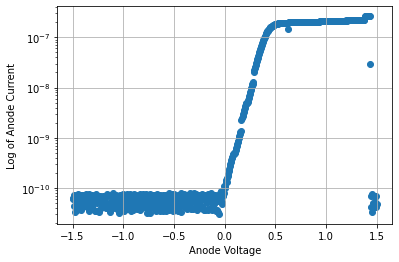

In [86]:
plt.scatter(iv,cmeasured)
plt.ylabel('Log of Anode Current')
plt.xlabel('Anode Voltage')
plt.yscale("log")
# plt.xlim(-1, -.3)
plt.grid(True)
print(len(iv))

In [74]:
finaldata = np.column_stack([iv, cmeasured])
np.savetxt("107.4mA.txt", finaldata, header='Input Voltage (V), Current (A)')